# Imports

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures


# Functions / Calc Column Defs
This code is pillaged from project #1 to allow my calculated columns to be config instead of hardcoded

In [2]:
# Calculated column definitions. These will be applied AFTER data cleansing, once dfClean (the clean dataset) is created
dictCalculatedColData = {
    # Example of a lookup, i.e. the value in new column "transaction fee" is based on the values in the "payment method" column
    "ConsoleGeneration": # Column to be created
        {
            "Column Type": "Lookup",
            "Data Type": "int64[pyarrow]",
            "Column Spec":
            {
                "Platform": # Column containing the categories we need to look up
                {
                    "2600": 2,
                    "3DS": 8,
                    "DC": 6,
                    "DS": 7,
                    "GB": 4,
                    "GBA": 6,
                    "GBC": 5,
                    "GC": 6,
                    "GEN": 4,
                    "N64": 5,
                    "NES": 3,
                    "NS": 8,
                    "PS": 5,
                    "PS2": 6,
                    "PS3": 7,
                    "PS4": 8,
                    "PSP": 7,
                    "PSV": 8,
                    "SAT": 5,
                    "SCD": 4,
                    "SNES": 4,
                    "Wii": 7,
                    "WiiU": 8,
                    "X360": 7,
                    "XB": 6,
                    "XOne": 8
                }
            }
        },
    "ConsoleManufacturer": # Column to be created
        {
            "Column Type": "Lookup",
            "Data Type": "string[pyarrow]",
            "Column Spec":
            {
                "Platform": # Column containing the categories we need to look up
                {
                    "2600": "Atari",
                    "3DS": "Nintendo",
                    "DC": "Sega",
                    "DS": "Nintendo",
                    "GB": "Nintendo",
                    "GBA": "Nintendo",
                    "GBC": "Nintendo",
                    "GC": "Nintendo",
                    "GEN": "Sega",
                    "N64": "Nintendo",
                    "NES": "Nintendo",
                    "NS": "Nintendo",
                    "PS": "Sony",
                    "PS2": "Sony",
                    "PS3": "Sony",
                    "PS4": "Sony",
                    "PSP": "Sony",
                    "PSV": "Sony",
                    "SAT": "Sega",
                    "SCD": "Sega",
                    "SNES": "Nintendo",
                    "Wii": "Nintendo",
                    "WiiU": "Nintendo",
                    "X360": "Microsoft",
                    "XB": "Microsoft",
                    "XOne": "Microsoft"
                }
            }
        },
    "GenreRollup": # Column to be created
        {
            "Column Type": "Lookup",
            "Data Type": "string[pyarrow]",
            "Column Spec":
            {
                "Genre": # Column containing the categories we need to look up
                {
                    "Action": "Action/Adventure",
                    "Action-Adventure": "Action/Adventure",
                    "Adventure": "Action/Adventure",
                    "Fighting": "Fighting",
                    "Misc": "Misc",
                    "MMO": "Role-Playing and MMO",
                    "Music": "Party/Music/Dance",
                    "Party": "Party/Music/Dance",
                    "Platform": "Platform",
                    "Puzzle": "Puzzle",
                    "Racing": "Racing",
                    "Role-Playing": "Role-Playing and MMO",
                    "Shooter": "Shooter",
                    "Simulation": "Simulation",
                    "Sports": "Sports",
                    "Strategy": "Strategy",
                }
            }
        },
    "PublisherType": # Column to be created
        {
            "Column Type": "2ColLookup",
            "Data Type": "string[pyarrow]",
            "Column Spec":
            {
                ("ConsoleManufacturer", "Publisher"): # Column containing the categories we need to look up
                {
                    ("Atari", "Atari"): "First Party",
                    ("Microsoft", "Microsoft"): "First Party",
                    ("Microsoft", "Microsoft Game Studios"): "First Party",
                    ("Microsoft", "Microsoft Studios"): "First Party",
                    ("Microsoft", "Mojang"): "First Party",
                    ("Nintendo", "Nintendo"): "First Party",
                    ("Sega", "Sega"): "First Party",
                    ("Sony", "Sony Computer Entertainment"): "First Party",
                    ("Sony", "Sony Computer Entertainment America"): "First Party",
                    ("Sony", "Sony Interactive Entertainment"): "First Party",
                    ("Sony", "Sony Online Entertainment"): "First Party",
                    ("DEFAULT_VALUE", "DEFAULT_VALUE"): "Third Party"
                }
            }
        }#,
    # Example of a column calculated based on other column values
    # "Total Transaction Fee": 
    # {
    #     "Column Type": "Function",
    #     "Data Type": "double[pyarrow]",
    #     "Column Spec": lambda row: round(row["Transaction Amount"] * row["Transaction Fee Pct"], 2)
    # },

    # # Another calculated column - notice that since we are going to end up applying these in order,
    # # column definitions can reference earlier columns.
    # "Total Transaction Amt": 
    # {
    #     "Column Type": "Function",
    #     "Data Type": "double[pyarrow]",
    #     "Column Spec": lambda row: round(row["Transaction Amount"] + row["Total Transaction Fee"], 2)
    # }
}

# Function to apply calculated columns
def calculated_columns(row, calc_col_def):
    # Get the calculation type from the column definition
    calc_col_type = calc_col_def["Column Type"]

    if calc_col_type == "Lookup":
        # Extract the key and value (which is our lookup dictionary) from calc_col_def
        for base_col_name, dictLookup in calc_col_def["Column Spec"].items():
            if row[base_col_name] in dictLookup:
                return dictLookup[row[base_col_name]]
            elif "DEFAULT_VALUE" in dictLookup:
                return dictLookup["DEFAULT_VALUE"]
            else:
                return None

    if calc_col_type == "2ColLookup":
            lookup_spec = calc_col_def["Column Spec"]
            # There should be exactly one item in Column Spec
            ((col1, col2), lookup_dict) = next(iter(lookup_spec.items()))

            # Create a tuple from the row values
            row_tuple = (row[col1], row[col2])
            
            # Print the row tuple for debugging
            #print("Row tuple:", row_tuple)
            
            # Check if the row tuple exists in the lookup dictionary
            if row_tuple in lookup_dict:
                #print("Key found:", row_tuple)
                return lookup_dict[row_tuple]
            
            # Check for default value
            if ("DEFAULT_VALUE", "DEFAULT_VALUE") in lookup_dict:
                #print("Returning default value")
                return lookup_dict[("DEFAULT_VALUE", "DEFAULT_VALUE")]
            
            # If no match is found, return None
            #print("No match found, returning None")
            return None

    # Default - i.e. the calculated column is of a type we have not written code to handle yet
    else:
        return None

# Read CSV File / Filter Dataframe

Process:
- Download top 2000 using web scraper script
- Clean up data by hand from other sources - missing years, incorrect genres

In [3]:
# Import the CSV file
df = pd.read_csv("https://raw.githubusercontent.com/candersen114/Python2Source/main/vgsales_new_final.csv", dtype_backend="pyarrow")

print(df.dtypes)

# Remove PC and PSN games, there aren't many and they aren't easily classified into generations
df = df[(df["Platform"] != "PSN") & (df["Platform"] != "PC")]

# Trim publisher and Genre to ensure standardization
df["Genre"] = df["Genre"].str.strip()
df["Publisher"] = df["Publisher"].str.strip()

df.describe(include="all")

Rank             int64[pyarrow]
Name            string[pyarrow]
Platform        string[pyarrow]
Year             int64[pyarrow]
Genre           string[pyarrow]
Publisher       string[pyarrow]
Developer       string[pyarrow]
Critic_Score    double[pyarrow]
User_Score      double[pyarrow]
NA_Sales        double[pyarrow]
PAL_Sales       double[pyarrow]
JP_Sales        double[pyarrow]
Other_Sales     double[pyarrow]
Global_Sales    double[pyarrow]
dtype: object


,Rank,Name,Platform,Year,Genre,Publisher,Developer,Critic_Score,User_Score,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Global_Sales
count,1936.0,1936,1936,1936.0,1936,1936,1936,1098.0,129.0,1878.0,1871.0,1306.0,1905.0,1936.0
unique,<NA>,1528,26,<NA>,16,103,456,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
top,<NA>,Minecraft,PS2,<NA>,Sports,Nintendo,Nintendo EAD,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
freq,<NA>,7,300,<NA>,293,345,69,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
mean,999.905475,NaN,NaN,2005.707645,NaN,NaN,NaN,8.117942,8.834109,1.499989,0.92016,0.573124,0.293433,3.019613
std,578.801568,NaN,NaN,7.538652,NaN,NaN,NaN,1.082233,1.05819,2.046652,1.338663,0.944822,0.501566,3.84032
min,1.0,NaN,NaN,1977.0,NaN,NaN,NaN,2.6,3.0,0.01,0.0,0.0,0.0,1.11
25%,496.75,NaN,NaN,2001.0,NaN,NaN,NaN,7.6,8.5,0.66,0.34,0.04,0.09,1.4
50%,1001.5,NaN,NaN,2007.0,NaN,NaN,NaN,8.3,9.1,1.0,0.56,0.16,0.17,1.895
75%,1499.25,NaN,NaN,2011.0,NaN,NaN,NaN,8.9,9.5,1.65,1.05,0.74,0.32,3.12


## Results
- The fact that all of our categorical data columns (rank, name, platform, year, genre, publisher, developer) have a count of 2000 is very promising - means no missing values in those columns
- Looks like some sales numbers are missing in certain regions. For some of this analysis, I think I'll want to create a subset that only looks at games available in North America and Japan.
- Japan is the video game capital of the world but seems to have fewer sales - probably because it's a smaller country. This means caution (and possibly "grading on a curve") will be needed when comparing results.
    - NA population in 2016 579 million
    - Japan population in 2016 roughly 127 million
    - This means that if there is a need to normalize comparisons between NA and Japan, Japanese sales figures can be multiplied x4.56
- PC and PSN games are included - they are not easily classified into generations. We'll exclude them because the numbers are very low.

# Calculated Columns

In [4]:
# Utilize dictCalculatedColData to apply our calculated columns
for calc_col_name, calc_col_def in dictCalculatedColData.items():
    print("Creating column ", calc_col_name)
    df[calc_col_name] = df.apply(calculated_columns, args=(calc_col_def,), axis=1)
    print("Applying data type ", calc_col_def["Data Type"], " to column ", calc_col_name)
    df[calc_col_name] = df[calc_col_name].astype(calc_col_def["Data Type"])

# Re-output dataframe statistics and sample data to ensure data cleansing was successful
print(df.dtypes)
display(df)
df.describe(include="all")
df.info()

Creating column  ConsoleGeneration
Applying data type  int64[pyarrow]  to column  ConsoleGeneration
Creating column  ConsoleManufacturer
Applying data type  string[pyarrow]  to column  ConsoleManufacturer
Creating column  GenreRollup
Applying data type  string[pyarrow]  to column  GenreRollup
Creating column  PublisherType
Applying data type  string[pyarrow]  to column  PublisherType
Rank                    int64[pyarrow]
Name                   string[pyarrow]
Platform               string[pyarrow]
Year                    int64[pyarrow]
Genre                  string[pyarrow]
Publisher              string[pyarrow]
Developer              string[pyarrow]
Critic_Score           double[pyarrow]
User_Score             double[pyarrow]
NA_Sales               double[pyarrow]
PAL_Sales              double[pyarrow]
JP_Sales               double[pyarrow]
Other_Sales            double[pyarrow]
Global_Sales           double[pyarrow]
ConsoleGeneration       int64[pyarrow]
ConsoleManufacturer    strin

,Rank,Name,Platform,Year,Genre,Publisher,Developer,Critic_Score,User_Score,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Global_Sales,ConsoleGeneration,ConsoleManufacturer,GenreRollup,PublisherType
0,1,Wii Sports,Wii,2006,Sports,Nintendo,Nintendo EAD,7.7,<NA>,41.36,29.02,3.77,8.51,82.65,7,Nintendo,Sports,First Party
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,Nintendo EAD,10.0,8.2,29.08,3.58,6.81,0.77,40.24,3,Nintendo,Platform,First Party
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,Nintendo EAD,8.2,9.1,15.91,12.92,3.8,3.35,35.98,7,Nintendo,Racing,First Party
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,Nintendo EAD,8.0,8.8,15.61,10.99,3.29,3.02,32.9,7,Nintendo,Sports,First Party
4,5,Pokémon Red / Green / Blue Version,GB,1998,Role-Playing,Nintendo,Game Freak,9.4,<NA>,11.27,8.89,10.22,1.0,31.37,4,Nintendo,Role-Playing and MMO,First Party
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,Red Dead Redemption: Undead Nightmare,X360,2010,Action,Rockstar Games,Rockstar San Diego,10.0,<NA>,0.61,0.38,0.02,0.1,1.11,7,Microsoft,Action/Adventure,Third Party
1996,1997,Metal Gear Solid HD Collection,PS3,2011,Action,Konami Digital Entertainment,Bluepoint Games,<NA>,<NA>,0.52,0.44,<NA>,0.14,1.11,7,Sony,Action/Adventure,Third Party
1997,1998,EA Sports UFC,PS4,2014,Fighting,Electronic Arts,EA Canada,<NA>,<NA>,0.49,0.43,0.01,0.18,1.11,8,Sony,Fighting,Third Party
1998,1999,NCAA Football 13,X360,2012,Sports,EA Sports,EA Tiburon,7.5,<NA>,1.02,<NA>,<NA>,0.09,1.11,7,Microsoft,Sports,Third Party


<class 'pandas.core.frame.DataFrame'>
Index: 1936 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   Rank                 1936 non-null   int64[pyarrow] 
 1   Name                 1936 non-null   string[pyarrow]
 2   Platform             1936 non-null   string[pyarrow]
 3   Year                 1936 non-null   int64[pyarrow] 
 4   Genre                1936 non-null   string[pyarrow]
 5   Publisher            1936 non-null   string[pyarrow]
 6   Developer            1936 non-null   string[pyarrow]
 7   Critic_Score         1098 non-null   double[pyarrow]
 8   User_Score           129 non-null    double[pyarrow]
 9   NA_Sales             1878 non-null   double[pyarrow]
 10  PAL_Sales            1871 non-null   double[pyarrow]
 11  JP_Sales             1306 non-null   double[pyarrow]
 12  Other_Sales          1905 non-null   double[pyarrow]
 13  Global_Sales         19

# Statistical Analysis

## Total Global Sales Distribution
Purpose: Determine if there are steep drop-offs in sales numbers... i.e. are high-sellers 1% of the data, 10%, 50%, etc.

/var/folders/cx/t4tmn45j49qdssz1t2jr1xwm0000gn/T/ipykernel_29459/1310272597.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ticks)


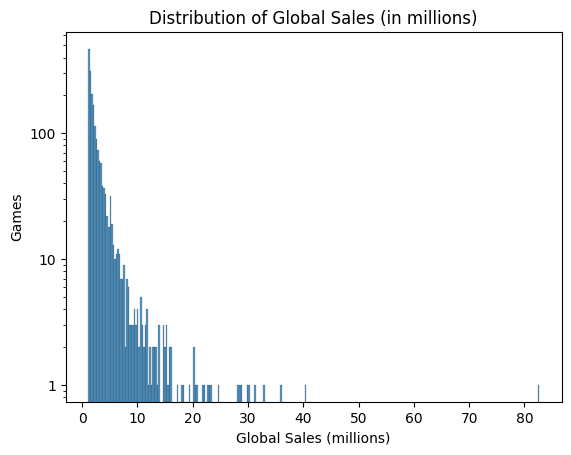

In [5]:
ax = sns.histplot(data=df, x="Global_Sales")
ax.set_title("Distribution of Global Sales (in millions)")
ax.set_xlabel("Global Sales (millions)")
ax.set_yscale("log")
ax.set_ylabel("Games")

# Set Y ticks (logarithmic)
ticks=[pow(10, -2), pow(10, -1), pow(10, 0), pow(10, 1), pow(10, 2), pow(10, 3), pow(10, 4)]
ax.set_yticklabels(ticks)

plt.show()

/var/folders/cx/t4tmn45j49qdssz1t2jr1xwm0000gn/T/ipykernel_29459/2372089091.py:5: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xbound(lower=0)
/var/folders/cx/t4tmn45j49qdssz1t2jr1xwm0000gn/T/ipykernel_29459/2372089091.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ticks)


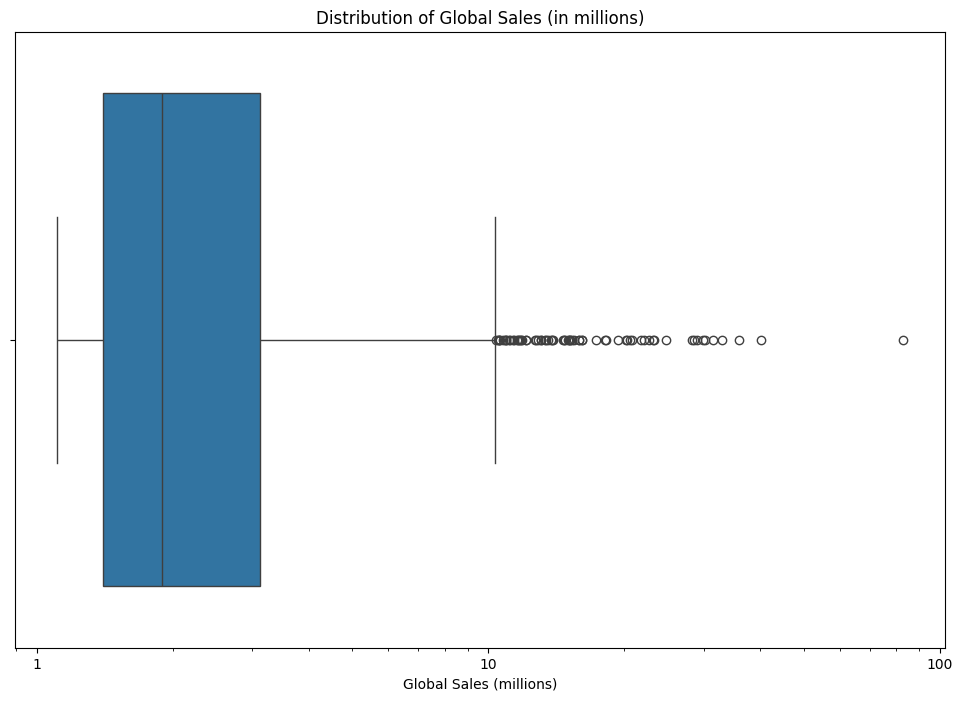

In [6]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=df, x="Global_Sales", log_scale=10)

# Set the X bound and tick labels to avoid 10^1, 10^2, etc
ax.set_xbound(lower=0)
ticks=[pow(10, -2), pow(10, -1), pow(10, 0), pow(10, 1), pow(10, 2), pow(10, 3), pow(10, 4)]
ax.set_xticklabels(ticks)

# Titles
ax.set_title("Distribution of Global Sales (in millions)")
ax.set_xlabel("Global Sales (millions)")

# Show Plot
plt.show()

## Games in Generation vs. Global Sales

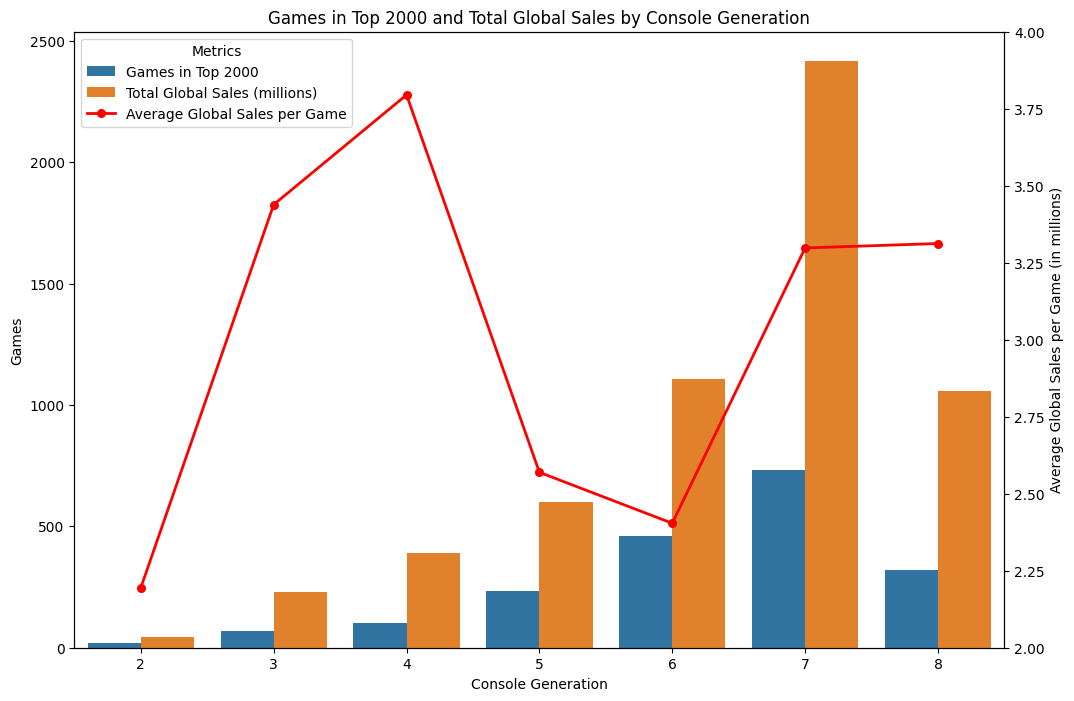

In [7]:
# Aggregate data
record_counts = df.groupby('ConsoleGeneration').size().reset_index(name='Games in Top 2000')
global_sales_sum = df.groupby('ConsoleGeneration')['Global_Sales'].sum().reset_index(name='Total Global Sales (millions)')

# Merge the two dataframes on ConsoleGeneration
merged_df = pd.merge(record_counts, global_sales_sum, on='ConsoleGeneration')

# Calculate the average global sales per game
merged_df['Average Global Sales per Game'] = merged_df['Total Global Sales (millions)'] / merged_df['Games in Top 2000']

# Melt the dataframe to a long format for easy plotting with seaborn
melted_df = pd.melt(merged_df, id_vars=['ConsoleGeneration'], value_vars=['Games in Top 2000', 'Total Global Sales (millions)'])

# Create the side-by-side bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='ConsoleGeneration', y='value', hue='variable', data=melted_df)

# Set Title
plt.title('Games in Top 2000 and Total Global Sales by Console Generation')

# Set X-axis label
plt.xlabel('Console Generation')

# Set Y-labels
ax.set_ylabel('Games')

# Create a secondary y-axis
ax2 = ax.twinx()
ax2.set_ylabel('Average Global Sales per Game (in millions)')
ax2.set_ylim(bottom=2, top=4)

# Plot the average global sales per game as a line plot
#ax2.plot(merged_df["ConsoleGeneration"], merged_df['Average Global Sales per Game'], color='red', marker='o', linestyle='-', linewidth=2, label='Average Global Sales per Game')
sns.pointplot(data=merged_df, x="ConsoleGeneration", y="Average Global Sales per Game", ax=ax2, color='red', marker='o', linewidth=2, label='Average Global Sales per Game')


# Combine the legends
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Create a combined legend
ax.legend(handles=handles1 + handles2, labels=labels1 + labels2, title='Metrics', loc='upper left')
ax2.legend_.remove()

plt.show()

## Genres of Top 2000 Games by Release Year

GenreRollup,Action/Adventure,Fighting,Misc,Party/Music/Dance,Platform,Puzzle,Racing,Role-Playing and MMO,Shooter,Simulation,Sports,Strategy
Year,,,,,,,,,,,,
1977,1.25,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1978,1.3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2.53,<NA>,<NA>,<NA>
1981,1.15,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,7.07,<NA>,<NA>,<NA>
1982,4.17,<NA>,<NA>,<NA>,5.96,9.46,<NA>,<NA>,6.36,<NA>,<NA>,<NA>
1983,<NA>,<NA>,2.14,<NA>,2.9,1.64,1.18,<NA>,1.12,<NA>,<NA>,<NA>
1984,<NA>,<NA>,1.45,<NA>,<NA>,<NA>,1.52,<NA>,<NA>,<NA>,<NA>,<NA>
1985,3.5,<NA>,1.85,<NA>,41.74,1.32,4.16,<NA>,29.58,<NA>,9.38,<NA>
1986,2.29,<NA>,<NA>,<NA>,11.51,<NA>,<NA>,<NA>,2.56,<NA>,<NA>,<NA>
1987,9.24,5.42,<NA>,<NA>,2.99,<NA>,1.96,1.25,<NA>,<NA>,7.19,<NA>


GenreRollup,Action/Adventure,Fighting,Misc,Party/Music/Dance,Platform,Puzzle,Racing,Role-Playing and MMO,Shooter,Simulation,Sports,Strategy
Year,,,,,,,,,,,,
1977,100.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1978,33.942559,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,66.057441,<NA>,<NA>,<NA>
1981,13.990268,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,86.009732,<NA>,<NA>,<NA>
1982,16.069364,<NA>,<NA>,<NA>,22.967245,36.454721,<NA>,<NA>,24.508671,<NA>,<NA>,<NA>
1983,<NA>,<NA>,23.830735,<NA>,32.293987,18.262806,13.140312,<NA>,12.47216,<NA>,<NA>,<NA>
1984,<NA>,<NA>,48.821549,<NA>,<NA>,<NA>,51.178451,<NA>,<NA>,<NA>,<NA>,<NA>
1985,3.823883,<NA>,2.021195,<NA>,45.602535,1.44215,4.544958,<NA>,32.317273,<NA>,10.248006,<NA>
1986,13.997555,<NA>,<NA>,<NA>,70.354523,<NA>,<NA>,<NA>,15.647922,<NA>,<NA>,<NA>
1987,32.941176,19.322638,<NA>,<NA>,10.659537,<NA>,6.987522,4.456328,<NA>,<NA>,25.632799,<NA>


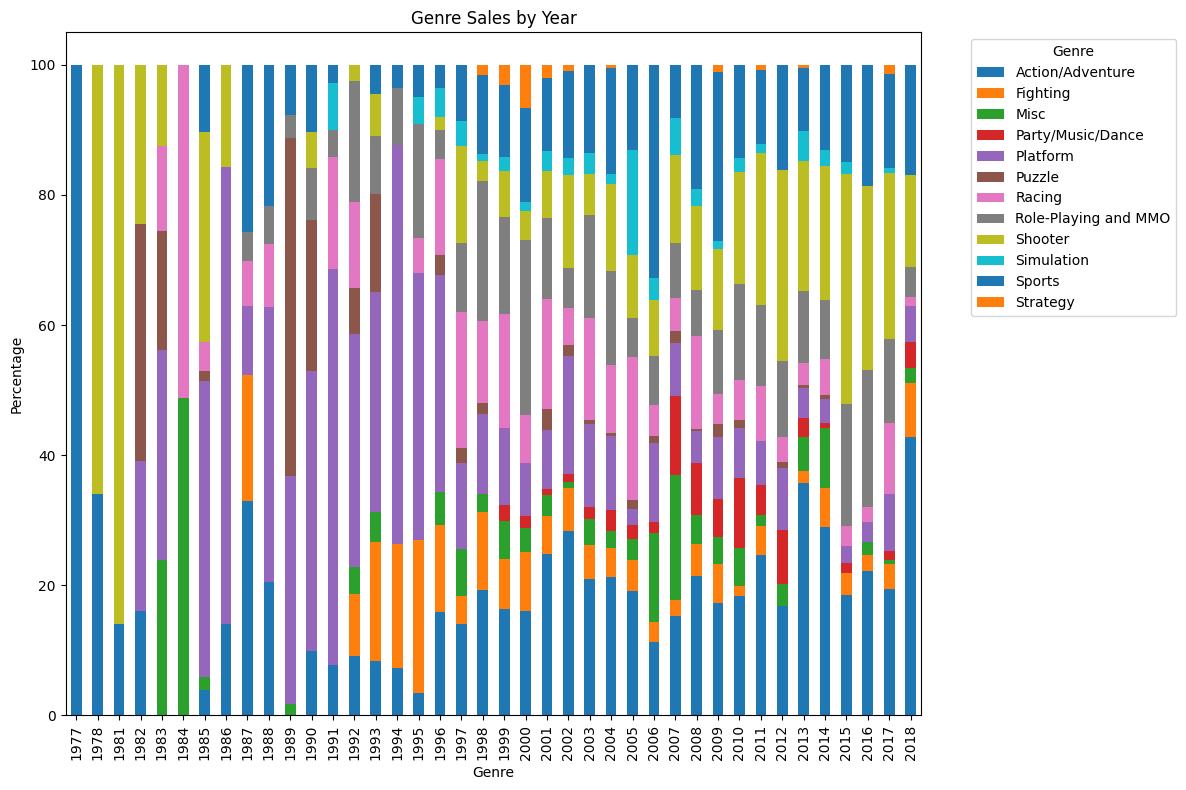

In [8]:
# Create a cross-tabulation of Year and Genre
genre_by_year = pd.crosstab(df["Year"], df["GenreRollup"], values=df["Global_Sales"], aggfunc='sum')

# Create the data for the X and Y axes
boxdata = genre_by_year.iloc[:, ::-1].cumsum(axis=1).stack().reset_index(name="Games")

genre_sales_percentage = genre_by_year.div(genre_by_year.sum(axis=1), axis=0) * 100
display(genre_by_year)
display(genre_sales_percentage)
# Plot the stacked 100% bar chart
plt.figure(figsize=(12, 8))
ax = plt.axes()
#sns.barplot(data=boxdata, x="Year", y="Games", hue="Genre", hue_order=genre_by_year.columns, dodge=False, palette="hsv")
genre_sales_percentage.plot(kind='bar', stacked=True, ax=ax)


# Set title and labels
plt.title('Genre Sales by Year')
plt.xlabel('Genre')
plt.ylabel('Percentage')

# Rotate x-labels for better visibility
plt.xticks(rotation=90)

plt.legend(title='Genre', loc='upper left', bbox_to_anchor=(1.05, 1))

# Show plot
plt.tight_layout()
plt.show()

## First Party vs Third Party by Manufacturer and Generation
Excluding Atari, due to low record count and lack of data beyond gen 2

Nintendo


PublisherType,First Party,Third Party,PercentFirstParty
ConsoleGeneration,,,
3,180.52,49.87,0.783541
4,290.97,69.23,0.807801
5,131.08,29.74,0.815073
6,159.14,88.23,0.643328
7,671.76,379.93,0.638743
8,309.27,33.69,0.901767


Microsoft


PublisherType,First Party,Third Party,PercentFirstParty
ConsoleGeneration,,,
6,24.82,60.43,0.291144
7,151.33,505.33,0.230454
8,40.39,161.74,0.199822


Sony


PublisherType,First Party,Third Party,PercentFirstParty
ConsoleGeneration,,,
5,118.86,315.93,0.273373
6,106.4,659.08,0.138998
7,138.98,570.1,0.196
8,90.2,421.34,0.17633


Sega


PublisherType,First Party,Third Party,PercentFirstParty
ConsoleGeneration,,,
4,18.05,12.63,0.588331
5,3.09,<NA>,<NA>
6,6.61,1.14,0.852903


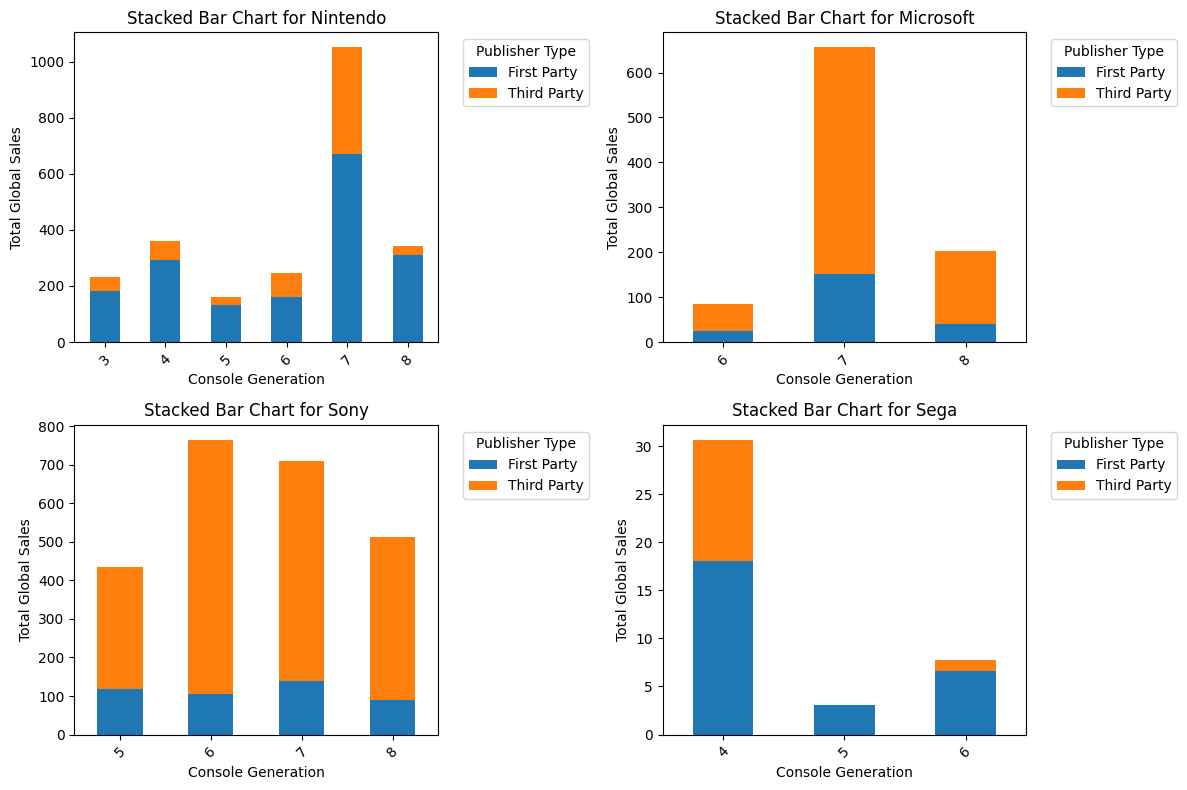

In [87]:
# Filter the dataframe for unique ConsoleManufacturers excluding "Atari"
manufacturers = df[df['ConsoleManufacturer'] != 'Atari']['ConsoleManufacturer'].unique()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Flatten the axes array to simplify iteration
axes = axes.flatten()

# Iterate over each manufacturer and corresponding subplot
for i, manufacturer in enumerate(manufacturers):
    # Filter dataframe for the current manufacturer
    manufacturer_df = df[(df['ConsoleManufacturer'] == manufacturer)]
    
    # Calculate sum of Global_Sales for each combination of ConsoleGeneration and PublisherType
    sales_by_generation_publisher = manufacturer_df.groupby(['ConsoleGeneration', 'PublisherType'])['Global_Sales'].sum().reset_index()
    
    # Pivot the dataframe to have PublisherType as columns
    sales_by_generation_publisher_pivot = sales_by_generation_publisher.pivot(index='ConsoleGeneration', columns='PublisherType', values='Global_Sales').fillna(0)
    
    # Plot stacked bar chart for ConsoleGeneration with hue representing PublisherType and total Global_Sales
    sales_by_generation_publisher_pivot.plot(kind='bar', stacked=True, ax=axes[i])
    
    # Set title and labels
    axes[i].set_title(f'Stacked Bar Chart for {manufacturer}')
    axes[i].set_xlabel('Console Generation')
    axes[i].set_ylabel('Total Global Sales')
    
    # Rotate x-labels for better visibility
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add legend outside of plot axes
    axes[i].legend(title='Publisher Type', loc='upper left', bbox_to_anchor=(1.05, 1))

    # Also show the underlying data
    dfpivot = sales_by_generation_publisher.pivot_table(index="ConsoleGeneration", columns="PublisherType", values="Global_Sales", aggfunc="sum")
    dfpivot["PercentFirstParty"] = dfpivot["First Party"] / (dfpivot["First Party"] + dfpivot["Third Party"])
    print(manufacturer)
    display(dfpivot)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()



The takeaway here is that Sony and Microsoft rely heavily on the licensing of third party game software, while Sega and Nintendo see stronger sales in their first-party titles.

## NA Sales vs JP Sales by Genre

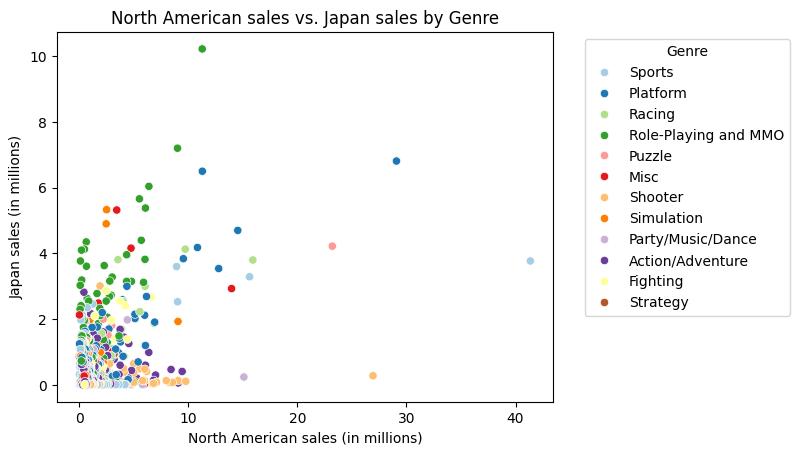

In [10]:
ax = sns.scatterplot(data=df, x="NA_Sales", y="JP_Sales", hue="GenreRollup", palette="Paired")
plt.legend(title='Genre', loc='upper left', bbox_to_anchor=(1.05, 1))

ax.set_title("North American sales vs. Japan sales by Genre")
ax.set_xlabel("North American sales (in millions)")
ax.set_ylabel("Japan sales (in millions)")

plt.show()

# Plot needs more cleanup

The results are largely mixed, but there are three distinct takeaways:
- Shooters show significantly higher popularity (in terms of sales) in North America compared to Japan
- Role-Playing Games and MMOs are more popular in Japan
- Aside from a handful of Sports games, most are popular in EITHER North America or Japan, suggesting a regional split depending on the popularity of a particular sport.

# Clustering

## Random Color List for Clustering

In [11]:
# build a list of 1000 random colors, because I got sick of having to add more colors as the number of clusters grew
colors = []
for i in range(1000):
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    rgbcode = "#" + f"{r:02x}" + f"{g:02x}" + f"{b:02x}"
    
    # ensure uniqueness AND make sure the color is not too close to white (FFFFFF - 255+255+255)
    # we'll use 720 as our threshold, meaning the "closest" color to white will be #F0F0F0, or 240+240+240
    while((rgbcode in colors) | (r+g+b > 720)):
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)
        rgbcode = "#" + f"{r:02x}" + f"{g:02x}" + f"{b:02x}"
    
    # We are now guaranteed to have a unique hex code that is not already in the list
    colors.append(rgbcode)

## Affinity Propagation

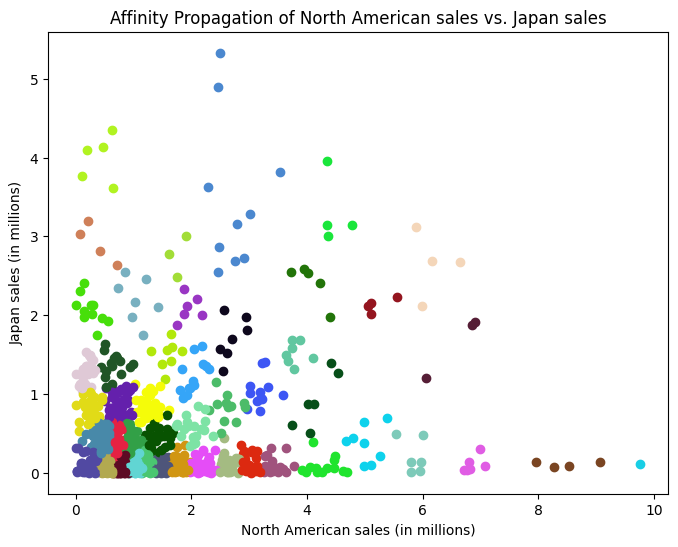

In [80]:
affinity = AffinityPropagation(damping=0.90, max_iter=1000)

# Drop rows with missing values in relevant columns
df_nona = df.dropna(subset=['NA_Sales', 'JP_Sales'])

# For the clustering dataset, we're going to focus on games with 20 million or fewer Global_Sales, to ensure the biggest outliers don't skew the clustering
df_nona = df_nona[df_nona["Global_Sales"] <= 15]

df_nona.reset_index(inplace=True)

cluster = affinity.fit(df_nona[["NA_Sales", "JP_Sales"]])

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
for i in df_nona.index:
    ax.scatter(df_nona["NA_Sales"][i], df_nona["JP_Sales"][i], color=colors[cluster.labels_[i]])

ax.set_title("Affinity Propagation of North American sales vs. Japan sales")
ax.set_xlabel("North American sales (in millions)")
ax.set_ylabel("Japan sales (in millions)")

plt.show()

## K-Means Clustering

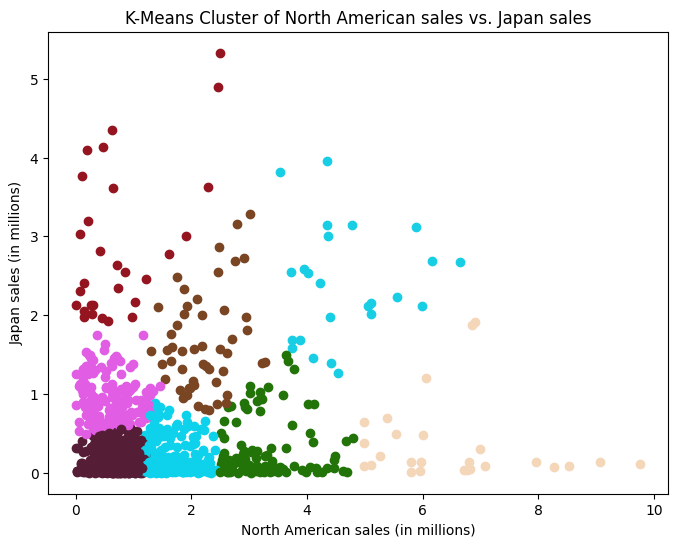

In [81]:
km = KMeans()

cluster = km.fit(df_nona[["NA_Sales", "JP_Sales"]])

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
for i in df_nona.index:
    ax.scatter(df_nona["NA_Sales"][i], df_nona["JP_Sales"][i], color=colors[cluster.labels_[i]])

ax.set_title("K-Means Cluster of North American sales vs. Japan sales")
ax.set_xlabel("North American sales (in millions)")
ax.set_ylabel("Japan sales (in millions)")

plt.show()

# Regression

We know that the 8th console generation data is under-represented (only est. 17% of sales included) because of digital sales and the fact that data collection ended after 2018 (prior to COVID and the 9th generation). So our regression strategy will be:
- Train a couple of models against generations 2-7
- Test the model against the <i>expected</i> sales for Gen 8 (actual sales / 0.17)
- Use the model that fits best to predict Gen 9 sales

## Subsets

In [33]:
# The data we know to be valid is gens 2-7; use that to train the model
gss_train = global_sales_sum[global_sales_sum["ConsoleGeneration"] < 8]

# Predict Gen 8 via the 17/83 ratio of physical to digital sales
# This will be used as a baseline against which each regression model
# will be tested
gss_gen8_calc = global_sales_sum[global_sales_sum["ConsoleGeneration"] == 8].copy()
gss_gen8_calc["Est. Global Sales, 83/17% Calc (millions)"] = gss_gen8_calc["Total Global Sales (millions)"] / 0.17

# Display the dataframes
display(gss_train)
display(gss_gen8_calc)

# Create the X-feature for the gen 2-9 prediction
x_pred_dict = {"ConsoleGeneration": [2, 3, 4, 5, 6, 7, 8, 9]}
x_pred = pd.DataFrame(x_pred_dict)

,ConsoleGeneration,Total Global Sales (millions)
0,2,46.09
1,3,230.39
2,4,390.88
3,5,598.7
4,6,1105.85
5,7,2417.43


,ConsoleGeneration,Total Global Sales (millions),"Est. Global Sales, 83/17% Calc (millions)"
6,8,1056.63,6215.470588


## Linear

MSE:  1.2111013342769092e-25
R2:  1.0


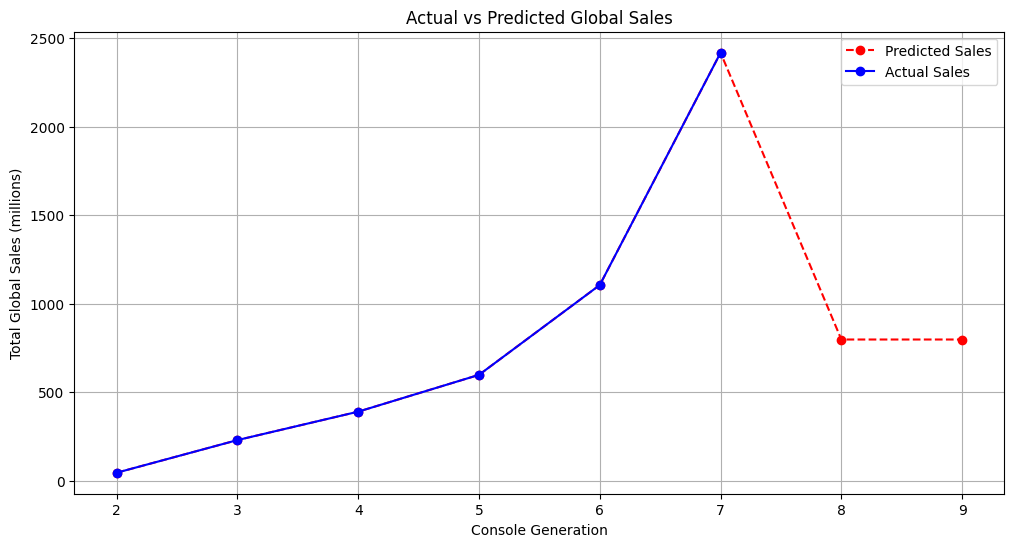

In [79]:
# One-hot encode the ConsoleGeneration column
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(x_pred)
x_train_encoded = encoder.transform(gss_train[["ConsoleGeneration"]])
x_pred_encoded = encoder.transform(x_pred)

# Create the linear regression model
lr = LinearRegression()
lr.fit(x_train_encoded, gss_train["Total Global Sales (millions)"])

# Test fit the model for purposes of calculating MSE and R2
lr_test_pred = lr.predict(x_train_encoded)

mse_lr = mean_squared_error(gss_train["Total Global Sales (millions)"], lr_test_pred)
r2_lr = r2_score(gss_train["Total Global Sales (millions)"], lr_test_pred)
print("MSE: ", mse_lr)
print("R2: ", r2_lr)

# Predict all generations based on the model
lr_sales_pred = lr.predict(x_pred_encoded)

# Plot the predictions vs actual sales
plt.figure(figsize=(12, 6))
plt.plot(x_pred["ConsoleGeneration"], lr_sales_pred, 'ro--', label='Predicted Sales')
plt.plot(gss_train["ConsoleGeneration"], gss_train["Total Global Sales (millions)"], 'bo-', label='Actual Sales')
plt.xlabel('Console Generation')
plt.ylabel('Total Global Sales (millions)')
plt.title('Actual vs Predicted Global Sales')
plt.legend()
plt.grid(True)
plt.show()

The linear model falls short for predictions. 8 and 9 should be rising, as the game sales have risen consistently from generation to generation. This is unfortunately the case despite having an R2 of 1 ("perfect") and a very low MSE. I'm keeping this code here for posterity, but will not be using it (aside from a passing reference) in the final writeup.

## Polynomial Regression

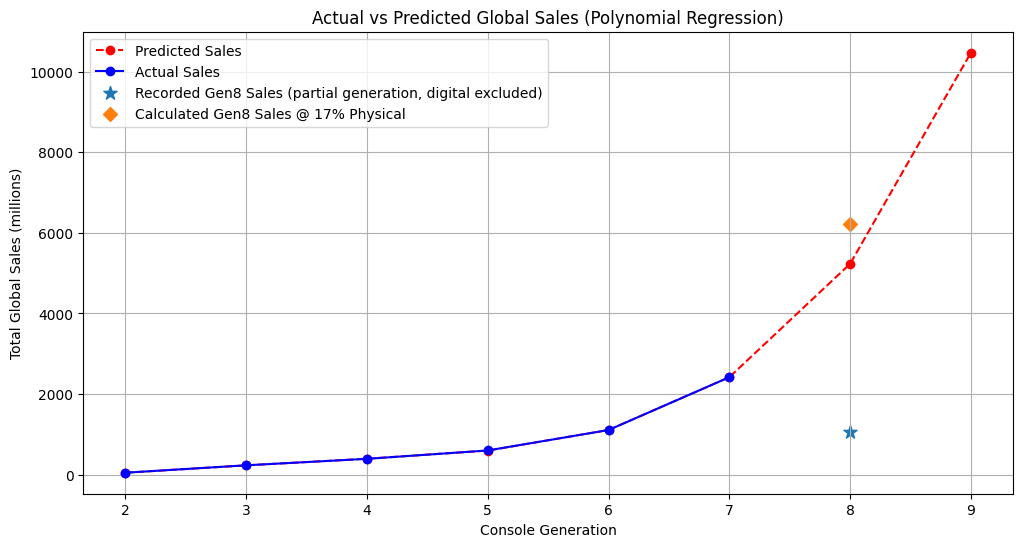

In [78]:
# Transform data for polynomial regression
poly = PolynomialFeatures(degree=4)  # Degree can be adjusted
X_train_poly = poly.fit_transform(gss_train[["ConsoleGeneration"]])
x_pred_poly = poly.transform(x_pred)

# Fit polynomial regression model
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, gss_train['Total Global Sales (millions)'])

# Predict with polynomial model
poly_sales_pred = lr_poly.predict(x_pred_poly)

# Visualization of polynomial regression results
plt.figure(figsize=(12, 6))
plt.plot(x_pred["ConsoleGeneration"], poly_sales_pred, 'ro--', label='Predicted Sales')
plt.plot(gss_train["ConsoleGeneration"], gss_train["Total Global Sales (millions)"], 'bo-', label='Actual Sales')
plt.scatter(gss_gen8_calc["ConsoleGeneration"], gss_gen8_calc["Total Global Sales (millions)"], s=100, marker="*", label="Recorded Gen8 Sales (partial generation, digital excluded)")
plt.scatter(gss_gen8_calc["ConsoleGeneration"], gss_gen8_calc["Est. Global Sales, 83/17% Calc (millions)"], s=50, marker="D", label="Calculated Gen8 Sales @ 17% Physical")
plt.xlabel('Console Generation')
plt.ylabel('Total Global Sales (millions)')
plt.title('Actual vs Predicted Global Sales (Polynomial Regression)')
plt.legend()
plt.grid(True)
plt.show()